In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

%config InlineBackend.figure_format = 'svg'

In [2]:
from samecode.plot.pyplot import subplots
from samecode.survival.plot import KMPlot

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [30]:
import tensorflow as tf
tf.__version__

'2.11.0'

In [4]:
# KMPlot.plot?
linewidth=2

t1 = 'IO'
ct = 'SOC'
KMARGS = dict(
    x_legend = 0.5, y_legend = 0.95, legend_font_size=8,
    comparisons=[
        ['{}_B+'.format(t1), '{}_B+'.format(ct), 'B+: '.format()],
        ['{}_B-'.format(t1), '{}_B-'.format(ct), 'B-: '.format()],
        ['{}_B+'.format(t1), '{}_B-'.format(t1), 'IO: '.format()],
        ['{}_B+'.format(ct), '{}_B-'.format(ct), 'SOC: '.format()]
    ],
    x_hr_legend = 0.0, y_hr_legend = 0.2, hr_font_size=8, 
    hr_color='black',
    linewidth=linewidth,
    template_color = '#8A8F91',
    linestyle=['--', '-', '--', '-'],
    show_censor=True
)

# From Poplar to OAK

## Dataset

In [5]:
dataset = pd.read_csv('../data/ML-ready-oak-poplar.tsv', sep='\t')

In [6]:
dataset['HIST'] = dataset['HIST'].replace(['NON-SQUAMOUS', 'SQUAMOUS'], [0, 1])
dataset['SEX'] = dataset['SEX'].replace(['F', 'M'], [0, 1])
dataset['TOBHX'] = dataset['TOBHX'].replace(['NEVER', 'PREVIOUS', 'CURRENT'], [0, 0.5, 1])

In [7]:
dataset = dataset[dataset.QC_Status == 'pass'].reset_index()

In [8]:
dataset['treat'] = dataset.Treatment.replace(['SOC', 'IO'], [0, 1])
dataset['OS_EVENT'] = 1 - dataset['OS.CNSR']
dataset['PFS_EVENT'] = 1 - dataset['PFS.CNSR']

In [9]:
mutations = list(dataset.columns[dataset.columns.str.match('mutations_')])

In [10]:
data_train, data_test = dataset[dataset.Study_x == 'POPLAR'],  dataset[dataset.Study_x == 'OAK']
data_train = data_train.reset_index(drop=True).copy()
data_test = data_test.reset_index(drop=True).copy()

data_train.shape, data_test.shape

((206, 843), (638, 843))

In [11]:
top_genes = list(data_train[mutations].sum().sort_values(ascending=False)[:20].keys())

## Model Parameters

In [12]:
time = 'OS'
event = 'OS_EVENT'
treatment = 'treat'

features = [  
    # Molecular derived features
    'blSLD',
    'btmb',
    'MSAF', 
    
    # Tumor characteristics
    'METSITES',
    'HIST',
    'ECOGGR',
    
    # Patient characteristics
    'SEX',
    'BAGE',
    'TOBHX',
]

top_genes = list(data_train[mutations].sum().sort_values(ascending=False)[:20].keys())

## PBMF Training

In [13]:
from PBMF.attention.model_zoo.SimpleModel import Net
from PBMF.attention.model_zoo.Ensemble import EnsemblePBMF

In [14]:
params = dict(
    ignore_patients_frac=0.1, # During training, ignore this % of patients before computing the loss
    layers=[64],
    epochs=500,
    minp=0.75, # force the model to get this minimum population (condition on w2, if w2=0 this variable is not relevant)
    w1=1.0, 
    w2=0.0,
    seed=0,
    embeddings_dim=32,
    learning_rate=0.01,
    shuffle=True,
    shuffle_features=False,
    l1=0.0,
)

In [15]:
pbmf = EnsemblePBMF(
    time=time, 
    event=event,
    treatment=treatment,
    stratify=treatment,
    features = features + top_genes,
    discard_n_features=1,
    architecture=Net, 
    **params
)

pbmf.fit(
    data_train, 
    num_models=100, 
    n_jobs=4,
    test_size=0.2, 
    outdir='./runs/emsemble_simple_model/',
    save_freq=100,
)

## PBMF Testing

In [16]:
pbmf = EnsemblePBMF()
pbmf.load(
    architecture=Net,
    outdir='./runs/emsemble_simple_model/',
    num_models=100,
)

In [26]:
data_train['consensus_risk'] = pbmf.predict(data_train, epoch=500)
data_test['consensus_risk'] = pbmf.predict(data_test, epoch=500)

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


In [27]:
B = ['B-', 'B+']

thr = 0.5

data_train['bin_risk'] = (data_train['consensus_risk'] > thr).replace([False, True], B)
data_test['bin_risk'] = (data_test['consensus_risk'] > thr).replace([False, True], B)

/opt/conda/lib/python3.10/site-packages/lifelines/utils/__init__.py:984: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  nonnumeric_cols = [col for (col, dtype) in df.dtypes.iteritems() if dtype.name == "category" or dtype.kind not in "biuf"]
/opt/conda/lib/python3.10/site-packages/lifelines/utils/__init__.py:984: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  nonnumeric_cols = [col for (col, dtype) in df.dtypes.iteritems() if dtype.name == "category" or dtype.kind not in "biuf"]
/opt/conda/lib/python3.10/site-packages/lifelines/utils/__init__.py:984: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  nonnumeric_cols = [col for (col, dtype) in df.dtypes.iteritems() if dtype.name == "category" or dtype.kind not in "biuf"]
/opt/conda/lib/python3.10/site-packages/lifelines/utils/__init__.py:984: FutureWarning: iteritems is deprecat

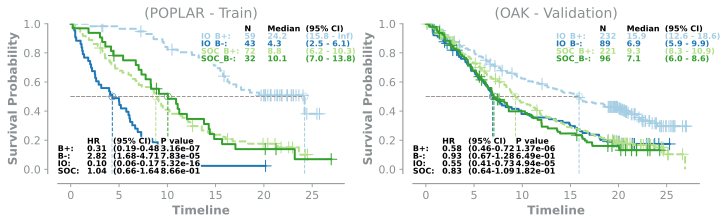

In [28]:
f, axs = subplots(cols=2, rows=1, w=10, h=3, return_f=True)

KMPlot(data_train, time=time, event=event, label=['Treatment', 'bin_risk']).plot(
    ax=axs[0],
    title='(POPLAR - Train)',
    **KMARGS
);


KMPlot(data_test, time=time, event=event, label=['Treatment', 'bin_risk']).plot(
    ax=axs[1],
    title='(OAK - Validation)',
    **KMARGS
);

sns.despine(offset=10);

In [29]:
data_train.to_csv('./train_predicted_scores.csv', index=False)
data_test.to_csv('./test_predicted_scores.csv', index=False)

# PBMF Pruning